## 1. 계단함수

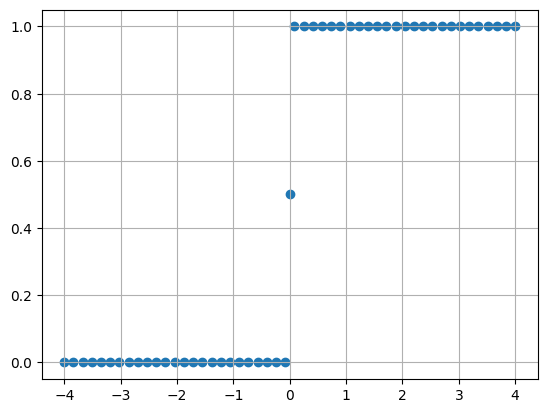

In [406]:
from scipy import stats as st
import numpy as np
from matplotlib import pyplot as plt

X_range=list(np.linspace(-4,4,50))
X_range.append(0)
X_range.sort()

def func(x):
    if x<0:
        return 0
    elif x==0:
        return 0.5
    else:
        return 1
    
y_range=np.array([func(x) for x in X_range])

plt.scatter(X_range,y_range)
plt.grid()

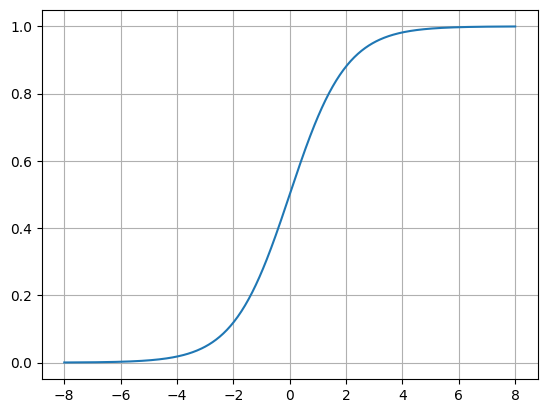

In [407]:
from scipy import stats as st
import numpy as np
from matplotlib import pyplot as plt

X_range=list(np.linspace(-8,8,500))
X_range.append(0)
X_range.sort()

def sigmoid(x):
    return 1/(1+np.exp(-x))
    
y_range=np.array([sigmoid(x) for x in X_range])

plt.plot(X_range,y_range)
plt.grid()

In [408]:
from pandas import read_csv
import numpy as np
from scipy import optimize as opt
from scipy import stats as st

In [409]:
data=read_csv("../데이터/고객대출등급예측.csv")

In [410]:
data

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,TRAIN_96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,TRAIN_96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,TRAIN_96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


---

1. 근로기간 특성 확인

In [411]:
from sklearn import preprocessing as pre
from sklearn import pipeline as pip
from sklearn import compose as com
from sklearn import base as base

In [412]:
test_num=data.대출기간.map(lambda x: "".join([num for num in x if num.isdigit()]))
test_alpha=data.대출기간.map(lambda x: "".join([num for num in x if num.isalpha()]))

기준이 months 인지 확인

In [413]:
test_alpha.unique()

array(['months'], dtype=object)

In [414]:
class LoanTime(base.BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.base_=["months"]
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X.map(lambda x: int("".join([num for num in x if num.isdigit()])))

In [415]:
test_pre=LoanTime()

In [416]:
test_pre.fit(data[["대출기간"]])

LoanTime()

In [417]:
test_pre.transform(data[["대출기간"]])

,대출기간
0,36
1,60
2,36
3,36
4,60
...,...
96289,36
96290,60
96291,36
96292,36


----

2. 주택소유상태 확인

In [418]:
house_stats=data.주택소유상태.unique()
print(house_stats)

['RENT' 'MORTGAGE' 'OWN' 'ANY']


---

3. 근로기간

In [419]:
data.근로기간.unique()

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

순위를 생성해야 전처리 가능합니다

In [420]:
working_time=list(data.근로기간.unique())

In [421]:
def remove_string(letter:str,rm_list:list):
    for rm_ in rm_list:
        letter=letter.replace(rm_,"")
    letter=letter.replace(" ","")
    return letter.strip()

In [422]:
['Unknown',"<1"]+[str(x) for x in range(1,10)]+["10+"]

['Unknown', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']

In [423]:
from numpy import ndarray
class WorkingTime(base.BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.ord_encoder=pre.OrdinalEncoder(
            categories=[['Unknown', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']],
            handle_unknown="use_encoded_value",
            unknown_value=-1
        )
    def fit(self,X,y=None):
        def remove_string(letter:str,rm_list:list):
            for rm_ in rm_list:
                letter=letter.replace(rm_,"")
            return letter.strip()
        tr_X=X.map(lambda x: remove_string(x,["years","year"]))
        self.ord_encoder.fit(tr_X)
        return self.ord_encoder
    def transform(self, X,y=None) -> ndarray:
        tr_X=X.map(lambda x: remove_string(x,["years","year"]))
        return self.ord_encoder.transform(tr_X)


In [424]:
test_ord=WorkingTime()

In [425]:
test_ord.fit(data[["근로기간"]])

OrdinalEncoder(categories=[['Unknown', '<1', '1', '2', '3', '4', '5', '6', '7',
                            '8', '9', '10+']],
               handle_unknown='use_encoded_value', unknown_value=-1)

In [426]:
test_ord.transform(data[["근로기간"]])

array([[ 7.],
       [11.],
       [ 6.],
       ...,
       [ 2.],
       [ 6.],
       [11.]])

4. 대출목적

In [427]:
purpose_loan=data.대출목적.unique()
print(purpose_loan)

['부채 통합' '주택 개선' '주요 구매' '휴가' '의료' '자동차' '신용 카드' '소규모 사업' '기타' '이사' '주택'
 '재생 에너지']


---

## 이진분류의 예시

In [428]:
data.대출등급.value_counts()

대출등급
B    28817
C    27623
A    16772
D    13354
E     7354
F     1954
G      420
Name: count, dtype: int64

B,C 의 샘플 개수가 굉장히 비슷함

따라서 이 둘을 가지고 이진분류 모델을 만들어 보겠습니다

In [429]:
bi_data=data[(data.대출등급=="B")|(data.대출등급=="C")]

#### 전처리 파이프 라인

In [430]:
from sklearn import pipeline as pip
from sklearn import compose as com
from sklearn import model_selection as mod
from sklearn import linear_model as lin

In [431]:
cates=[house_stats,purpose_loan]
one_hot=pre.OneHotEncoder(categories=cates,handle_unknown="ignore",drop="if_binary")

num_cols=bi_data.select_dtypes(np.number).columns.to_list()


prepreocess_=com.ColumnTransformer((("대출기간",LoanTime(),["대출기간"]),
                      ("근로기간",WorkingTime(),["근로기간"]),
                      ("이산형특성",one_hot,["주택소유상태","대출목적"]),
                      ("연속형특성","passthrough",num_cols)),
                      remainder="drop",verbose=True)

확인

In [432]:
prepreocess_.fit(bi_data)

[ColumnTransformer] .......... (1 of 4) Processing 대출기간, total=   0.0s
[ColumnTransformer] .......... (2 of 4) Processing 근로기간, total=   0.0s
[ColumnTransformer] ......... (3 of 4) Processing 이산형특성, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing 연속형특성, total=   0.0s


ColumnTransformer(transformers=(('대출기간', LoanTime(), ['대출기간']),
                                ('근로기간', WorkingTime(), ['근로기간']),
                                ('이산형특성',
                                 OneHotEncoder(categories=[array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object),
                                                           array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지'], dtype=object)],
                                               drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['주택소유상태', '대출목적']),
                                ('연속형특성', 'passthrough',
                                 ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                                  '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                                  '연체계좌수'])),
                  verbose=True)

In [433]:
prepreocess_.transform(bi_data)

array([[3.60000e+01, 7.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [6.00000e+01, 1.10000e+01, 0.00000e+00, ..., 2.34060e+05,
        0.00000e+00, 0.00000e+00],
       [3.60000e+01, 9.00000e+00, 0.00000e+00, ..., 1.53108e+05,
        0.00000e+00, 0.00000e+00],
       ...,
       [3.60000e+01, 0.00000e+00, 0.00000e+00, ..., 6.20328e+05,
        0.00000e+00, 0.00000e+00],
       [3.60000e+01, 1.10000e+01, 0.00000e+00, ..., 4.92168e+05,
        0.00000e+00, 0.00000e+00],
       [3.60000e+01, 1.10000e+01, 1.00000e+00, ..., 2.74956e+05,
        0.00000e+00, 0.00000e+00]])

### 로지스틱 회귀 모델 만들기

In [434]:
LogitRg=pip.Pipeline([("전처리",prepreocess_),
                      ("로지스틱회귀",lin.LogisticRegression())])

In [435]:
LogitRg.fit(X=bi_data,y=bi_data["대출등급"])

[ColumnTransformer] .......... (1 of 4) Processing 대출기간, total=   0.0s
[ColumnTransformer] .......... (2 of 4) Processing 근로기간, total=   0.1s
[ColumnTransformer] ......... (3 of 4) Processing 이산형특성, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing 연속형특성, total=   0.0s


Pipeline(steps=[('전처리',
                 ColumnTransformer(transformers=(('대출기간', LoanTime(), ['대출기간']),
                                                 ('근로기간', WorkingTime(),
                                                  ['근로기간']),
                                                 ('이산형특성',
                                                  OneHotEncoder(categories=[array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object),
                                                                            array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지'], dtype=object)],
                                                                drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['주택소유상태', '대출목적']),
                                                 ('연속형특성', 'passthrough',
                                                  ['대출금액', '연간소득',
                                                   '부채_대비_소득_비율', '총계좌수',
                                                   '최근_2년간_연체_횟수', '총상환원금',
                                                   '총상환이자', '총연체금액',
                                                   '연체계좌수'])),
                                   verbose=True)),
                ('로지스틱회귀', LogisticRegression())])

### 교차검증 진행

10겹 10차로 진행하며, 혼동행렬을 확인하겠습니다.

In [ ]:
from sklearn import model_selection as mod
from sklearn import metrics as met

precision_score=met.make_scorer(met.precision_score,pos_label="B")
recall_score=met.make_scorer(met.recall_score,pos_label="B")
accuracy_score=met.make_scorer(met.accuracy_score)

kfold=mod.RepeatedStratifiedKFold(n_splits=10,n_repeats=10,random_state=1)

history=mod.cross_validate(estimator=LogitRg,X=bi_data,y=bi_data["대출등급"],cv=kfold,
                           scoring={"accuracy":accuracy_score,
                                    "precision":precision_score,
                                    "recall":recall_score})

In [437]:
history["test_accuracy"].mean()

np.float64(0.7144737774627924)

In [438]:
history["test_accuracy"].std()

np.float64(0.006366163396915021)

----

## 사이킷런

In [515]:
from sklearn import datasets as skdata
from pandas import DataFrame
import numpy as np

In [524]:
data=skdata.load_iris(as_frame=True,return_X_y=True)
X=DataFrame(data[0])
y=DataFrame(data[1])
name_map=dict(zip([0,1,2],['setosa', 'versicolor', 'virginica']))

y.target=y.target.map(lambda x:name_map[x])

이진분류를 위해 타겟 데이터 ["setosa","versicolor"] 만 사용

In [525]:
y=y[(y=="setosa")|(y=="versicolor")]
named_y=y.copy()

y.dropna(inplace=True)
X=X.loc[y.index]

y=y.map(lambda x: 1 if x=="setosa" else 0)

### 시그모이드 함수 선언

In [442]:
def sigmoid(x:int):
    return 1/(1+np.exp(-x))

### 손실함수 계산

In [443]:
def proba_loss(y_true,y_proba):
    return (y_proba**y_true)*((1-y_proba)**(1-y_true))

예를 들어보자

In [444]:
y_true=1
y_proba=0.7

In [445]:
proba_loss(y_true,y_proba)

0.7

### 선형모델 만들기

In [446]:
constant=np.ones(shape=(X.shape[0],1))
X_addconstant=np.append(X.values,constant,axis=1)

In [447]:
def logit(w:np.array,x:np.array):
    return sigmoid(w@x)

In [448]:
x=X_addconstant[0]
w=np.random.randn(X_addconstant.shape[1])

함수 벡터화

In [449]:
sigmoid_=np.vectorize(sigmoid)
proba_loss_=np.vectorize(proba_loss)

In [450]:
y_proba=sigmoid_(X_addconstant@w.T)
y_proba

array([0.19049014, 0.25813929, 0.22127333, 0.24090856, 0.17673932,
       0.14480593, 0.18900088, 0.2049997 , 0.26465707, 0.25440527,
       0.17322186, 0.20495503, 0.26466072, 0.24463943, 0.13850312,
       0.10015024, 0.13561688, 0.18388039, 0.16501432, 0.15219155,
       0.21779926, 0.15724631, 0.16063411, 0.20492666, 0.21443073,
       0.2673969 , 0.19416575, 0.19495987, 0.20504436, 0.23128401,
       0.24800018, 0.19725248, 0.13385974, 0.12101433, 0.24625238,
       0.22299122, 0.19353247, 0.18170802, 0.24544328, 0.20657984,
       0.179608  , 0.3584403 , 0.216316  , 0.16908018, 0.15647233,
       0.24809892, 0.16043355, 0.22289627, 0.17184161, 0.21546451,
       0.28717395, 0.25946929, 0.30110538, 0.40005082, 0.33367798,
       0.33156632, 0.24125338, 0.36622275, 0.336901  , 0.30466763,
       0.45704076, 0.27090135, 0.46394477, 0.32085172, 0.27599082,
       0.28633746, 0.27650349, 0.36464766, 0.43854725, 0.37943327,
       0.23681454, 0.31913553, 0.39952488, 0.35873336, 0.32002

### 경사하강법

In [485]:
np.random.seed(1)
w_0=np.random.randn(X_addconstant.shape[1])
w_0=w_0.reshape(5,-1)

In [483]:
print(w_0)

[[ 1.62434536]
 [-0.61175641]
 [-0.52817175]
 [-1.07296862]
 [ 0.86540763]]


In [573]:
def partial_loss(w:np.array,X:np.array,y:np.array):
    p_1=sigmoid_(X@w)
    return -X.T@(y-p_1),p_1

In [574]:
partial_loss(w_0,X_addconstant,y.values)[0]

array([[294.06742467],
       [137.0184329 ],
       [211.31353654],
       [ 65.79484704],
       [ 49.50201689]])

In [595]:
def log_loss(p_1:np.array,y:np.array):
    return (y.T@p_1)+(1-y).T@(1-p_1)

경사하강법 실행

In [597]:
mu=0.01
epochs=1000

w_history=[w_0]
loss_history=[]
for i in range(epochs):
    w=w_history[-1]

    p_l,p_1=partial_loss(w,X_addconstant,y.values)
    loss=log_loss(p_1,y.values)

    new_w=w-mu*p_l

    w_history.append(new_w)
    loss_history.append(loss)

In [501]:
final_proba=sigmoid_(X_addconstant@w_history[-1])

In [602]:
print(loss_history)

[array([[50.19193656]]), array([[50.0000039]]), array([[93.69656331]]), array([[94.2298396]]), array([[94.67904675]]), array([[95.05395679]]), array([[95.38584895]]), array([[95.66868791]]), array([[95.92775481]]), array([[96.15057784]]), array([[96.35366323]]), array([[96.53140704]]), array([[96.6931195]]), array([[96.83859036]]), array([[96.97159088]]), array([[97.09319479]]), array([[97.20503591]]), array([[97.30819735]]), array([[97.40368182]]), array([[97.49232238]]), array([[97.57483946]]), array([[97.65185445]]), array([[97.72390703]]), array([[97.7914681]]), array([[97.85495046]]), array([[97.91471755]]), array([[97.97109058]]), array([[98.02435456]]), array([[98.07476327]]), array([[98.12254343]]), array([[98.16789821]]), array([[98.21101025]]), array([[98.25204419]]), array([[98.29114882]]), array([[98.32845899]]), array([[98.36409716]]), array([[98.39817486]]), array([[98.43079381]]), array([[98.46204706]]), array([[98.49201982]]), array([[98.52079034]]), array([[98.54843057

In [504]:
hold_func=np.vectorize(lambda x: 1 if x>=0.5 else 0)

In [506]:
pred_y=hold_func(final_proba)
from sklearn import metrics as met

met.confusion_matrix(y_pred=pred_y,y_true=y.values)

array([[50,  0],
       [ 0, 50]])

In [530]:
named_y.dropna(inplace=True)

In [564]:
from sklearn import linear_model as lin

logit_rg=lin.LogisticRegression(penalty=None,max_iter=1000)
logit_rg.fit(X=X.values,y=named_y.values.ravel())

LogisticRegression(max_iter=1000, penalty=None)

In [621]:
print("w :",logit_rg.coef_)
print("b :",logit_rg.intercept_,"\n\n")

print("w` :",np.append(logit_rg.coef_,logit_rg.intercept_))

w : [[-1.14991583 -4.38686873  6.58470792  3.18988247]]
b : [-0.63879236] 


w` : [-1.14991583 -4.38686873  6.58470792  3.18988247 -0.63879236]


In [618]:
logit_rg.predict_proba(X.values)[:,0]

array([9.99993861e-01, 9.99930729e-01, 9.99981231e-01, 9.99878158e-01,
       9.99995559e-01, 9.99989739e-01, 9.99976727e-01, 9.99979369e-01,
       9.99809139e-01, 9.99937271e-01, 9.99996507e-01, 9.99949840e-01,
       9.99943511e-01, 9.99986076e-01, 9.99999918e-01, 9.99999783e-01,
       9.99999263e-01, 9.99991554e-01, 9.99991809e-01, 9.99995624e-01,
       9.99951394e-01, 9.99990665e-01, 9.99999495e-01, 9.99722964e-01,
       9.99638476e-01, 9.99769601e-01, 9.99924571e-01, 9.99989429e-01,
       9.99991514e-01, 9.99864698e-01, 9.99812992e-01, 9.99975349e-01,
       9.99999447e-01, 9.99999820e-01, 9.99913703e-01, 9.99993119e-01,
       9.99997994e-01, 9.99996378e-01, 9.99936279e-01, 9.99981610e-01,
       9.99995095e-01, 9.98318064e-01, 9.99973499e-01, 9.99907937e-01,
       9.99916164e-01, 9.99893092e-01, 9.99993856e-01, 9.99959323e-01,
       9.99996081e-01, 9.99983439e-01, 3.08863073e-06, 4.20271436e-06,
       3.45805887e-07, 1.46661596e-06, 4.22108736e-07, 6.15095402e-07,
      

In [566]:
logit_rg.coef_

array([[-1.14991583, -4.38686873,  6.58470792,  3.18988247]])

In [563]:
w_history[-1]

array([[ 1.57256424],
       [ 1.87048668],
       [-4.87244755],
       [-2.94255075],
       [ 1.16056837]])

In [551]:
final_proba.ravel()

array([9.99755833e-01, 9.99148498e-01, 9.99506989e-01, 9.98159161e-01,
       9.99762998e-01, 9.99440066e-01, 9.99133193e-01, 9.99439356e-01,
       9.97749446e-01, 9.99143428e-01, 9.99829403e-01, 9.98750929e-01,
       9.99257433e-01, 9.99621950e-01, 9.99987968e-01, 9.99948229e-01,
       9.99920216e-01, 9.99672324e-01, 9.99686096e-01, 9.99695659e-01,
       9.99208192e-01, 9.99507614e-01, 9.99936674e-01, 9.96311411e-01,
       9.94634421e-01, 9.98074079e-01, 9.98357854e-01, 9.99660407e-01,
       9.99748451e-01, 9.97876897e-01, 9.97812834e-01, 9.99461604e-01,
       9.99917611e-01, 9.99964847e-01, 9.98850709e-01, 9.99810986e-01,
       9.99920022e-01, 9.99793335e-01, 9.98852039e-01, 9.99520899e-01,
       9.99764402e-01, 9.95142102e-01, 9.99210023e-01, 9.97548612e-01,
       9.97139302e-01, 9.98663208e-01, 9.99630898e-01, 9.99061215e-01,
       9.99800357e-01, 9.99584685e-01, 1.41086100e-04, 1.08429359e-04,
       2.81186664e-05, 1.00694857e-04, 3.68917309e-05, 3.07440689e-05,
      

In [555]:
plot_=np.array(w_history)[:,:2]

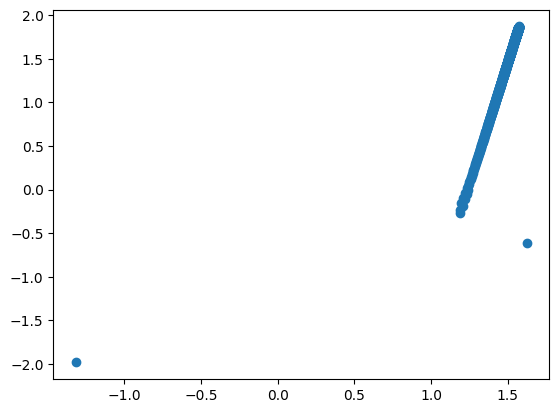

In [558]:
from matplotlib import pyplot as plt

plt.scatter(plot_[:,0],plot_[:,1])

In [609]:
m=len([x.ravel() for x in loss_history])

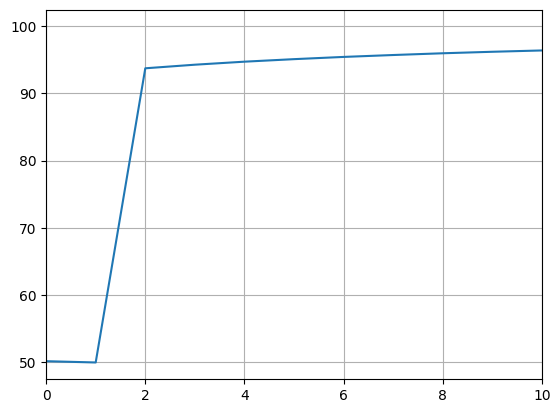

In [615]:
plt.plot(range(m),[x.ravel() for x in loss_history])
plt.xlim(0,10)
plt.grid()